![logo](../../LogoLine_horizon_C3S.png)

# Evaluation of the hit-rate of seasonal forecasts for tercile categories of monthly anomalies

Production date: 30/05/2024

Produced by: Sandro Calmanti (ENEA), Alessandro Dell'Aquila (ENEA)

## 🌍 Use case: A national hydro-met service informing decisions in agricultural or energy applications


## ❓ Quality assessment questions
* **What are the hit-rates for terciles categories in seasonal forecasts for anomalies above/below normal?** 
* **Can I use information from seasonal forecasts of monthly anomalies to make decisions?**

Seasonal forecasts are not deterministic: they are not expected to provide quantitative information on the value of climate parameters with an attached error bar.

Instead, **seasonal forecasts are probabilistic**: they provide information on how climate parameters are expected to change over the coming months, compared to climatology, in terms of their main statistical aspects, given the current state of the climate system.

A key issue regarding the usability of seasonal forecasts is that end-users do not always have a way to incorporate a probability distribution function (PDF) related to a climate variability in their decision workflow. Many practical decisions, for which seasonal forecast might be beneficial require some form of binary choice [[1]](https://doi.org/10.1016/j.cliser.2024.100496), for example:

 - Do I have to plan for an anticipated harvest?
 - Do I have to choose the long-cycle or short-cycle maize variety for the coming season?
 - Will the coming season allow a reduced number of treatments for my crops?
 - Do I have to purchase in advance, and at a lower price, an extra stock of dispatchable energy for air conditioning?

This notebook focuses on the **hit-rate** for terciles categories in seasonal forecasts, a simple yet fundamental building block for measuring the quality, and potential value, of seasonal forecasts. 

The hit-rate (also mentioned sometimes as _hit-score_) addresses the key question: how often did the forecasted category with the highest probability actually occur? As such, the hit-rate for terciles categories describes a basic attribute of probabilistic forecasts, i.e. that the outcome of a given season is expected to differ from the normal if the forecast differs from the normal. This characteristic of probabilistic forecasts is called **resolution**.

A complementary aspect in describing the quality of seasonal forecasts is **discrimination**, which is the answer to the opposite question: do the forecasts differ when the outcome differ? As an example if, on average, a forecasting system issues always the same forecast, regardless of the expected outcome, there can be some _hits_ in the forecast but, at the same time, the forecast would not be able to discriminate the occurrence of an event from a non-event. Discrimination is best measured by **Relative Operating Characteristic (ROC)** scores.

As long as there is some resolution or discrimination, there is a potential to extract some valuable information from the forecasts.

Indeed, the WMO [Guidance on Verification of Operational Seasonal Climate Forecasts](https://library.wmo.int/idurl/4/56227) highlights how the use of generalised methodologies for the assessment of seasonal forecasts sometimes represent limited attraction for new users. Therefore, the [Guidance](https://library.wmo.int/idurl/4/56227) recommends a range of methodologies of increasing complexity, including very simple ones like the hit-rate, which are particularly useful for introducing the potential value of seasonal forecasts to non-specialists.

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* The hit-rate for terciles cetegories of seasonal forecasts in predicting anomalies at a monthly time-scale depends significantly on the variable and on the region of interest. 
* The hit-rates for terciles of different variables do not depend significantly on the forecasting system. 
* The larger hit-rates for terciles of monthly anomalies (above 70%) are for 2m temperatures in regions surrounding the Pacific, under the direct influence of El Niño [[2]](https://doi.org/10.1038/s41612-023-00519-8).
* The usability and value of seasonal forecasts must be assessed on a case-by-case basis, by explicitly accounting for the impact on the decision at stake [[3]](https://doi.org/10.1002/wcc.523).
```

```{figure} a684544d-7232-4092-82a5-7ec01184a99a.png
---
height: 500px
---
The figure shows a sample  of the hit-rate for terciles of ECMWF monthly anomalies for 2m temperature over South East Asia as a function of the starting month and of the valid month of the forecast. More details on how to interpret the results are available below in the notebook.
```

## 📋 Methodology

This notebook provides a comprehensive assessment of the hit-rates for terciles on monthly anomalies of selected ECVs of the forecast systems by comparing the model predictions with the ERA5 reanalysis. The analysis is carried out for eight regions selected from those used in the IPCC-AR6 (see figure below) [[4]](https://doi.org/10.1017/CBO9781139177245.006).

The computation of the hit-score is straightforward: the monthly values of the selected ECV (e.g. temperature)  are firstly divided in terciles (below normal, normal, above normal). Then, the hit-score is computed by counting the number of events when the most populated tercile derived from the distribution of the seasonal forecasts corresponds to the observed tercile of the target month. 

The analysis and results are organised in the following steps, which are detailed in the sections below:

**[](seasonal_seasonal-monthly-single-levels_forecast-skill_q04:section-1):**
 * Import required packages
 * Define parameters describing regions, variables, and data
 * Plot the chosen regions
 * Define functions for the tercile analysis
 * Define plot function

**[](seasonal_seasonal-monthly-single-levels_forecast-skill_q04:section-2):**
 * Download and process ERA5
 * Download and process seasonal forecast data

**[](seasonal_seasonal-monthly-single-levels_forecast-skill_q04:section-3)**
 * Analysis of terciles
 * Compute hit-score and show a sample plot

**[](seasonal_seasonal-monthly-single-levels_forecast-skill_q04:section-4):** 
 * Hit-rate for terciles of 2m temperature 
 * Hit-rate for terciles of other variables

## 📈 Analysis and results

(seasonal_seasonal-monthly-single-levels_forecast-skill_q04:section-1)=
### 1. Choose the data to use and setup the code

#### Import required packages 

The package `regionmask` is used to mask out the SREX regions selected for the analysis.

In [1]:
import tempfile

import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import regionmask
import scipy.stats
import xarray as xr

from c3s_eqc_automatic_quality_control import diagnostics, download
from matplotlib.colors import ListedColormap

plt.style.use("seaborn-v0_8-notebook")

#### Define parameters describing regions, variables, and data

The analysis of hit-scores is conducted over 5 different variables  for the 8 originating centres. The AR6 regions selected for the analysis are.

- NEAF: Northern-East Africa
- ENA: Eastern North America
- MED: Southern Europe/Mediterranean
- NES: Eastern Coast of South America
- SAS: Southern Asia
- SEA: South-Eastern Asia
- WNA: Western North America
- NWS: Western Coast of South America

A `common_request` is defined to cover the entire global domain and the entire hindcast period from 1993 to 2016. Specific data requests are then defined for the reanalysis and for the seasonal forecasts, so that all available months and lead times are retrieved for the analysis.

In [2]:
# Time
year_start_hindcast = 1993
year_stop_hindcast = 2016

# Detrend timeseries
detrend = False
assert isinstance(detrend, bool)

# Variable
variables = [
    "2m_temperature",
    "total_precipitation",
    "surface_solar_radiation_downwards",
    "10m_wind_speed",
    "2m_dewpoint_temperature",
]

# Define centres with missing variables
missing_variables = {"eccc": ["2m_dewpoint_temperature"]}

# Centres
centres = {
    "cmcc": {"system": "35"},
    "dwd": {"system": "21"},
    "eccc": {"system": "3"},
    "ecmwf": {"system": "51"},
    "jma": {"system": "3"},
    "meteo_france": {"system": "8"},
    "ncep": {"system": "2"},
    "ukmo": {"system": "601"},
}
assert all("system" in v for v in centres.values())
assert set(centres) <= {
    "cmcc",
    "dwd",
    "eccc",
    "ecmwf",
    "jma",
    "meteo_france",
    "ncep",
    "ukmo",
}

# Regions
defined_regions_module_name = "ar6.land"
regions = [
    "ENA",
    "MED",
    "NEAF",
    "NES",
    "NWS",
    "SAS",
    "SEA",
    "WNA",
]


# Define data requests
chunks = {"year": 1, "variable": 1}
common_request = {
    "format": "grib",
    "area": [89.5, -179.5, -89.5, 179.5],
    "year": [str(year) for year in range(year_start_hindcast, year_stop_hindcast + 1)],
}

collection_id_reanalysis = "reanalysis-era5-single-levels-monthly-means"
request_reanalysis = common_request | {
    "product_type": "monthly_averaged_reanalysis",
    "month": [f"{month:02d}" for month in range(1, 13)],
    "time": "00:00",
}

collection_id_seasonal = "seasonal-monthly-single-levels"
request_seasonal = common_request | {
    "product_type": "monthly_mean",
    "leadtime_month": list(map(str, range(1, 7))),
    "month": [f"{month:02d}" for month in range(1, 13)],
    "grid": "1/1",
}

#### Plot the chosen regions
For the bias analysis we use 8 out of the 46 AR6 regions defined in the `regionmask` package in order to assess the systematic errors of the modelling systems under different climatic regimes (tropical, extratropical, continental, maritime) with a number of cases manageable within the notebook.

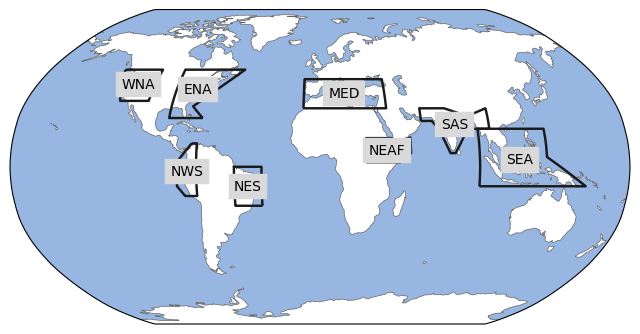

In [3]:
def get_defined_regions(defined_regions_module_name):
    defined_regions = regionmask.defined_regions
    for module in defined_regions_module_name.split("."):
        defined_regions = getattr(defined_regions, module)
    return defined_regions


defined_regions = get_defined_regions(defined_regions_module_name)
assert set(regions) <= set(defined_regions.abbrevs)

ax = defined_regions[regions].plot(
    projection=ccrs.Robinson(),
    label="abbrev",
    add_ocean=True,
)
ax.set_global()

#### Define the required functions

- The function `reindex_seasonal_forecast` is necessary in the tercile analysis to align the valid time of the forecast to the corresponding date in the reanalysis.

- The function `tercile_analysis` converts the value of both ERA5 data and seasonal forecast data into the corresponding tercile value, which corresponds to below normal, normal, and above normal. The processing of ERA5 and of seasonal forecasts is detailed below.


**Processing of ERA5**

1.	Compute the mean monthly temperature from the reanalysis over the selected AR6 regions.

2. If required, remove the linear trend to emphasise hit-scores associated to natural climate variability rather than to long-term tendencies. This step may be of interest for the analysis of hit-scores for temperature. By default, detrending is not applied in the analysis presented in this notebook. However, the code cell shows how to implement the detrending procedure. 

3.	For each month, and for each region, compute the values associated to the 33-th and 66-th percentile of the corresponding monthly distribution

4.	Convert the series of mean monthly temperature anomalies over each region into the corresponding terciles, using the following conversion table:  

   - -1 = below normal, values below the 33-th percentile
   - 0 , values between the 33-th and the 66-th percentile
   - 1 = above normal, values above the 33-th percentile

**Processing of seasonal forecasts**

1.	Apply step 1. as for ERA5 for each seasonal forecasting system. In this case there is a different temperature anomaly for each originating centre, starting time and valid time for the forecast.

2. If required, apply step 2. as for ERA5 to remove linear trends.

3. Apply step 3. as for ERA5 to obtain the position of the terciles for each originating centre and for each starting time and valid time. In this case, the underlying distribution for the computation of the terciles includes all years in the hindcast as well as all ensemble members. The 33-th and 66-th percentiles depend on the lead-time, i.e. the difference between valid time and starting time, so that the analysis accounts for potential model drifts. In the present analysis, we consider a maximum lead-time of six months. 

4. Apply step 4. as for ERA5 to convert temperature anomalies into the corresponding terciles for all regions, for all time months and valid time, and for each member of the ensemble forecast.

5. For seasonal forecasts the most likely tercile in the forecast is derived by computing the mode of the terciles (step 3) over all the ensemble members. The most likely terciles is an array whose dimensions are the originating centres, the region, the starting time and the valid time. 

In [5]:
def mode(*args, axis=None, **kwargs):
    return scipy.stats.mode(*args, axis=axis, **kwargs).mode


def reindex_seasonal_forecast(ds):
    # Stack starting_time and leading_month
    ds = ds.rename(forecast_reference_time="starting_time")
    ds = ds.stack(
        time=("starting_time", "leadtime_month"),
        create_index=False,
    )

    # Shift valid_time
    ds = ds.set_index(time="starting_time")
    valid_time = ds.indexes["time"]
    for shift in set(ds["leadtime_month"].values):
        shifted = ds.indexes["time"].shift(shift - 1, "MS")
        valid_time = valid_time.where(ds["leadtime_month"] != shift, shifted)

    # Reindex: valid_time and starting_month
    coords = {
        "valid_time": ("time", valid_time),
        "starting_month": ("time", ds["time"].dt.month.data),
    }
    ds = ds.assign_coords(coords)
    ds = ds.set_index({"time": tuple(coords)}).unstack("time")
    return ds

def plot_tercile_analysis(da, **kwargs):
    cmap = kwargs.pop("cmap", "RdYlBu_r")
    kwargs["cmap"] = plt.get_cmap(cmap, 3)
    cbar_kwargs = {"ticks": [-2 / 3, 0, 2 / 3]}

    plot_obj = da.plot(cbar_kwargs=cbar_kwargs, **kwargs)

    cbar = (
        plot_obj.cbar
        if isinstance(plot_obj, xr.plot.facetgrid.FacetGrid)
        else plot_obj.colorbar
    )
    cbar.ax.set_yticklabels(["Below normal", "Normal", "Above Normal"])
    return plot_obj

def tercile_analysis(ds, region, defined_regions_module_name, detrend):
    # Mask region
    defined_regions = get_defined_regions(defined_regions_module_name)
    mask = defined_regions.mask(ds)
    index = defined_regions.map_keys(region)
    ds = ds.where((mask == index).compute(), drop=True)
    ds = ds.expand_dims(region=[region])

    # Spatial mean
    ds = diagnostics.spatial_weighted_mean(ds)

    if "leadtime_month" in ds.dims:
        ds = reindex_seasonal_forecast(ds)
    else:
        ds = ds.rename(forecast_reference_time="valid_time")

    if detrend:
        # Detrend timeseries
        time = ds["valid_time"]
        fit = ds.polyfit(time.name, deg=1, w=time.dt.days_in_month)
        fit = fit.rename(
            {var: var.replace("_polyfit_coefficients", "") for var in fit.data_vars}
        )
        ds -= xr.polyval(time, fit)

    # Compute anomaly
    climatology = diagnostics.time_weighted_mean(ds, time_name="valid_time")
    climatology = climatology.mean(set(climatology.dims) & {"realization"})
    ds -= climatology

    # Reindex using valid year/month month
    time = ds["valid_time"]
    coords = {
        "valid_year": (time.name, time.dt.year.data),
        "valid_month": (time.name, time.dt.month.data),
    }
    ds = ds.assign_coords(coords)
    ds = ds.set_index({time.name: tuple(coords)}).unstack(time.name)

    # Get quantiles
    quantiles = ds.chunk(valid_year=-1).quantile([1 / 3, 2 / 3], "valid_year")
    low = quantiles.sel(quantile=1 / 3)
    high = quantiles.sel(quantile=2 / 3)
    mask = xr.full_like(ds, None)
    mask = xr.where(ds < low, -1, mask)
    mask = xr.where((ds >= low) & (ds <= high), 0, mask)
    mask = xr.where(ds > high, 1, mask)

    if "realization" in mask.dims:
        # Get mode
        mask = mask.reduce(mode, dim="realization")

    return mask.reset_coords(drop=True)

(seasonal_seasonal-monthly-single-levels_forecast-skill_q04:section-2)=
### 2. Download and process data

#### Download and process ERA5

ERA5 data are converted to tercile values by applying the function `tercile_analysis`. The outcome of the download and transform process is a three-dimensional array containing tercile values, i.e. (-1, 0, 1) for ("_Below normal_, _Normal_, _Above Normal_") respectively, for each of the 8 regions, for 25 years and 12 months each year.

The final outcome of the tercile analysis for each variable is an array with the following dimensions:

 > -  valid_year: 25
 > -  valid_month: 12
 > -  region: 8

A separate array is created for each of the 5 selected variables. All arrays are assembled into a single `xarray` dataset for the following computation and visualisations steps.

In [ ]:
# Get the reanalysis data
datasets = []
for region in regions:
    dataarrays = []
    for variable in variables:
        print(f"{region=} {variable=}")
        ds = download.download_and_transform(
            collection_id_reanalysis,
            request_reanalysis | {"variable": variable},
            chunks=chunks,
            transform_chunks=False,
            transform_func=tercile_analysis,
            transform_func_kwargs={
                "region": region,
                "defined_regions_module_name": defined_regions_module_name,
                "detrend": detrend,
            },
        )
        (da,) = ds.data_vars.values()
        dataarrays.append(da.rename(variable))
    ds = xr.merge(dataarrays)
    datasets.append(ds)
ds_reanalysis = xr.concat(datasets, "region")
del datasets

#### Download and process seasonal forecasts
Similarly to ERA5 data, seasonal forecast data are converted to tercile values by applying the function `tercile_analysis`. However, in this case the outcome of the download and transform process is a five-dimensional array: besides the 8 regions, 25 years and 12 months corresponding to the valid time of the forecasts, two additional dimensions are necessary to account for the 8 originating centres and for the 12 possible starting months of the forecast. For each starting month, there are 6 tercile values that correspond to the length of the forecast taken into account, whereas the tercile values for the other six months are set to Not-a-Number. 

The final outcome of the tercile analysis for each variable is an array with the following dimensions:

 > -  valid_year: 25
 > -  valid_month: 12
 > -  starting_month: 12
 > -  region: 8
 > -  centre: 8

All arrays are assembled into a single `xarray` dataset containing all variables for the following computation and visualisations steps.

In [ ]:
# Get the seasonal forecast data - DETREND
datasets = []
for centre, request_kwargs in centres.items():
    for region in regions:
        dataarrays = []
        for variable in variables:
            print(f"{centre=} {region=} {variable=}")
            if variable in missing_variables.get(centre, []):
                print("SKIP")
                continue

            with tempfile.TemporaryDirectory() as TMPDIR:
                ds = download.download_and_transform(
                    collection_id_seasonal,
                    request_seasonal
                    | {"originating_centre": centre, "variable": variable}
                    | request_kwargs,
                    chunks=chunks,
                    transform_chunks=False,
                    transform_func=tercile_analysis,
                    transform_func_kwargs={
                        "region": region,
                        "defined_regions_module_name": defined_regions_module_name,
                        "detrend": detrend,
                    },
                    backend_kwargs={
                        "time_dims": (
                            "forecastMonth",
                            (
                                "indexing_time"
                                if centre in ["ukmo", "jma", "ncep"]
                                else "time"
                            ),
                        )
                    },
                )
            (da,) = ds.data_vars.values()
            dataarrays.append(da.rename(variable))
        ds = xr.merge(dataarrays)
        datasets.append(ds.expand_dims(centre=[centre]))
ds_seasonal = xr.merge(datasets)
del datasets

(seasonal_seasonal-monthly-single-levels_forecast-skill_q04:section-3)=
### 3. Hit-score analysis

#### Analysis of terciles

Splitting the distribution of climate parameters into terciles is a simple way of converting probabilistic forecasts into binary information that a user of climate information can consult to make decisions. 

For example, a user may ask whether the coming months will be warmer (or colder) than normal, and the answer would be "likely yes" or "likely no" depending on which is the most likely anomaly in the forecast. As a working hypothesis, it is reasonable to assume that specific actions are undertaken when a significant deviation from the norm is expected, for example planting a drought resistant but less productive maize variety if less rainfall than normal is expected, or purchasing in advance, and at a lower price, an extra stock of dispatchable energy for air conditioning systems if warmer than normal conditions are expected during summer. 

For the analysis presented in this notebook, the forecasting system scores a hit if the observed monthly anomaly matches the corresponding forecast.

To illustrate how the hit-score analysis works, the three figures below show an example mean 2m temperature over South East Asia, using ECMWF System 5.1 as a sample seasonal forecast. 

- The first figure shows a complete series of the terciles derived from ERA5 as a function of year and month. For example, the year 1998, during which a strong El Niño event has been registered, is characterised by a sequence of temperature anomalies above normal, starting from December 1997 to October 1998. Instead, the year 2008, a strong La Niña year, shows a sequence of below normal anomalies. 

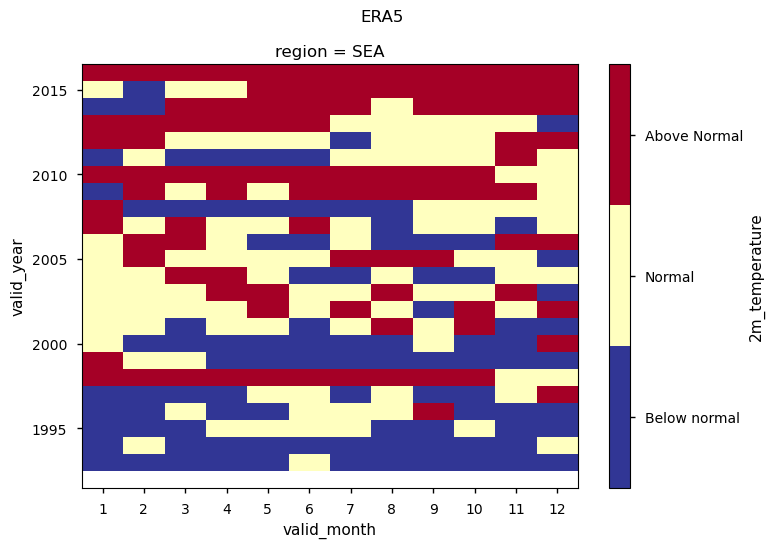

In [8]:
variable='2m_temperature'
centre='ecmwf'
region='SEA'
assert (variable in variables) and (region in regions) and (centre in centres)

plot_tercile_analysis(
    ds_reanalysis[variable].sel(region=region),
    xticks=range(1, 13),
)
plt.suptitle("ERA5")
plt.show()

- The second figure shows, read from below to the top, the tercile analysis for the seasonal forecasts issued during 1998. Each row in the panel corresponds to a single six-month forecast issued at the corresponding starting month on the vertical axis. For the year 1998 most of the forecast starts with a temperature anomaly above normal and persists in this status until the end of the six-month period. Forecasts starting at the end of the previous year, which are represented in the top-left corner of the panel, also start with a warm anomaly that persists throughout the forecast. Since 1998 was a warm year in this region, most of the monthly anomalies of 1998 count as a hit for the forecasts issued in 1998 at all lead times. 

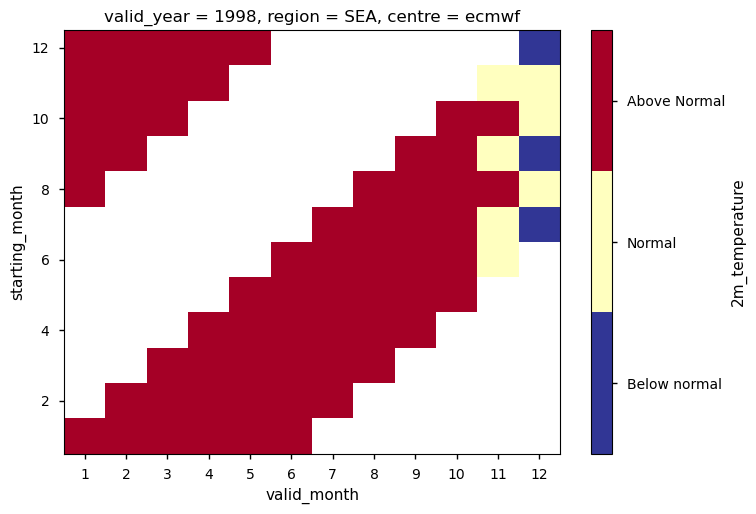

/data/common/miniforge3/envs/wp3/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/data/common/miniforge3/envs/wp3/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


In [9]:
year=1998
plot_tercile_analysis(
    ds_seasonal[variable].sel(region=region,centre=centre,valid_year=year),
    xticks=range(1, 13),
)
#plt.suptitle("ERA5")
plt.show()

#### Compute hit-score and show a sample plot

By counting the number of hits for all available hindcasts and considering the hits on anomalies both above and below normal, it is possible to obtain a systematic assessment of the hit-rates for terciles on monthly anomalies. Similar hit-scores may also be considered, but for the categories with second- and third- highest probabilities. Other adjustments to the scores may be considered, as suggested by the [WMO Guidance](https://library.wmo.int/idurl/4/56227), by assigning for example a half hit if one of two categories with tied highest probability verifies.

In this assessment we consider the simplest possible definition:

$Hit \: rate = 100 * \frac{Number \: of \: hits}{Number \: of \: forecasts}$

The figure below, which should be read from the bottom to the top, shows in each row the hit rate on monthly anomalies of the forecast starting from the corresponding month indicated on the vertical axis. 

For example, the forecasts starting in June (month 6) have a hit-rate above 90% for the first month of the forecast, which is reduced to a value between 80% and 90% for the second month (July). During the following months (August to November) the hit-rate decreases further but remains mostly above 70%. 

Note that the horizontal axis is periodic and the tiles in the top left corner of the panel represent the hit-rates for terciles of the forecasts started in August or later during the year. 

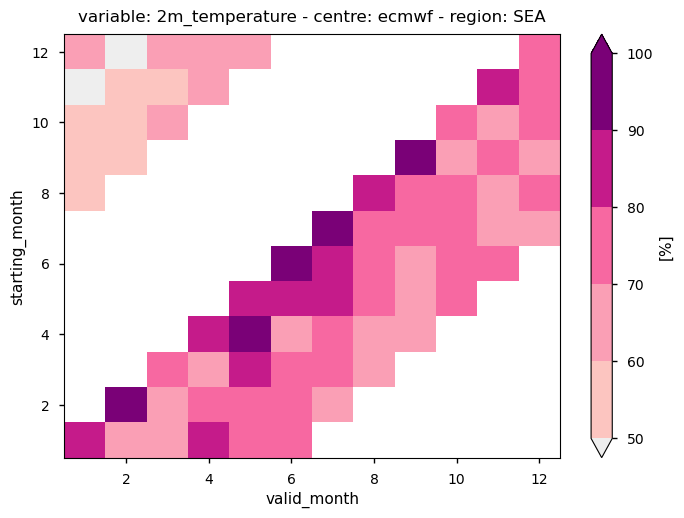

In [10]:
# Compute hit rates
mask_threshold = 50.
masked_ds_seasonal = ds_seasonal.where(ds_seasonal != 0)
hit_rate = (masked_ds_seasonal == ds_reanalysis).sum("valid_year")
hit_rate *= 100 / masked_ds_seasonal.notnull().sum("valid_year")

hit_rate_mask = hit_rate
hit_rate_mask = xr.where(hit_rate < mask_threshold, 0, hit_rate)


# Define the custom colormap
hr_cmap = ['#eeeeee','#fcc5c0','#fa9fb5','#f768a1','#c51b8a','#7a0177','#7a0177']
custom_cmap = ListedColormap(hr_cmap)


#This adjustment allow maz hit-rate values to be correctly represented with the color palette
#hit_rate_mask = xr.where(hit_rate == 100., 99.9, hit_rate)

hit_rate_mask.attrs = {"long_name": "Hit-Rate", "units": "%"}
ax = hit_rate_mask["2m_temperature"].sel(centre=centre,region=region).plot(x="valid_month",
                                                                           cmap=custom_cmap, 
                                                                           levels = np.arange(mask_threshold,110.,10.),
                                                                           extend='both')
ax.colorbar.set_label(f"[{hit_rate_mask.attrs['units']}]")
_ = plt.title(f"variable: {variable} - centre: {centre} - region: {region}", y=1.01)

(seasonal_seasonal-monthly-single-levels_forecast-skill_q04:section-4)=
### 4. Plot and describe results

#### Hit-rate for 2 m temperature

The same analysis described in section 3 above. can be replicated for all forecasting systems and for all the selected sample regions. 

Overall, the seasonal forecasts of 2m temperature have a significant, and potentially usable, hit-rate for terciles in regions closer to the tropics and under the direct influence of El Niño. The further away from the tropics, the lower the expected hit-rate on monthly anomalies. 

Hit-rates smaller than 50% have been masked out, with the assumption that lower hit-rates would be of limited use for most practical applications. Although this working hypothesis can not be assumed to be strictly true for all purposes, it is a useful assumption for a discussion on the general characteristics of seasonal forecasts [[3]](https://doi.org/10.1002/wcc.523) [[5]](https://doi.org/10.1016/j.crm.2021.100375) [[6]](https://doi.org/10.1016/j.cliser.2023.100347) [[7]](https://doi.org/10.1016/j.cliser.2023.100346).

The figure below shows that, among the sample regions considered in this analysis, those with the higher and more persistent hit-rate are South East Asia (SEA) and North West South America (NWS). These areas are under the direct influence of ENSO and are expected to benefit from a significantly higher degree of predictability compared to other regions. Other areas with significant, and potentially usable, in practical applications are Northern-East Africa (NEAF) and (North East South America) NES. Other areas like Southern Asia (SAS) and Souther Europe/Mediterranean (MED) have a moderate hit-rate, limited mostly to short lead times, whereas NWS shows only scattered cases of hit-rate above 50% [[2]](https://doi.org/10.1038/s41612-023-00519-8) [[8]](https://doi.org/10.1175/BAMS-D-19-0019.1) [[9]](https://doi.org/10.1175/WAF-D-19-0106.1) [[10]](https://doi.org/10.1007/s00704-018-2421-9).

Compared to the similar assessment conducted ([](./seasonal_seasonal-monthly-single-levels_forecast-skill_q02.ipynb)), a significant aspect of the hit-rates for terciles is their weak dependence on the originating centre. Although minor differences exist in the performance of the different forecasting systems, the overall patterns of significant hit-rates and even their seasonality is very similar, e.g. higher hit-rates in North West South America during the period October-December associated to El Niño.

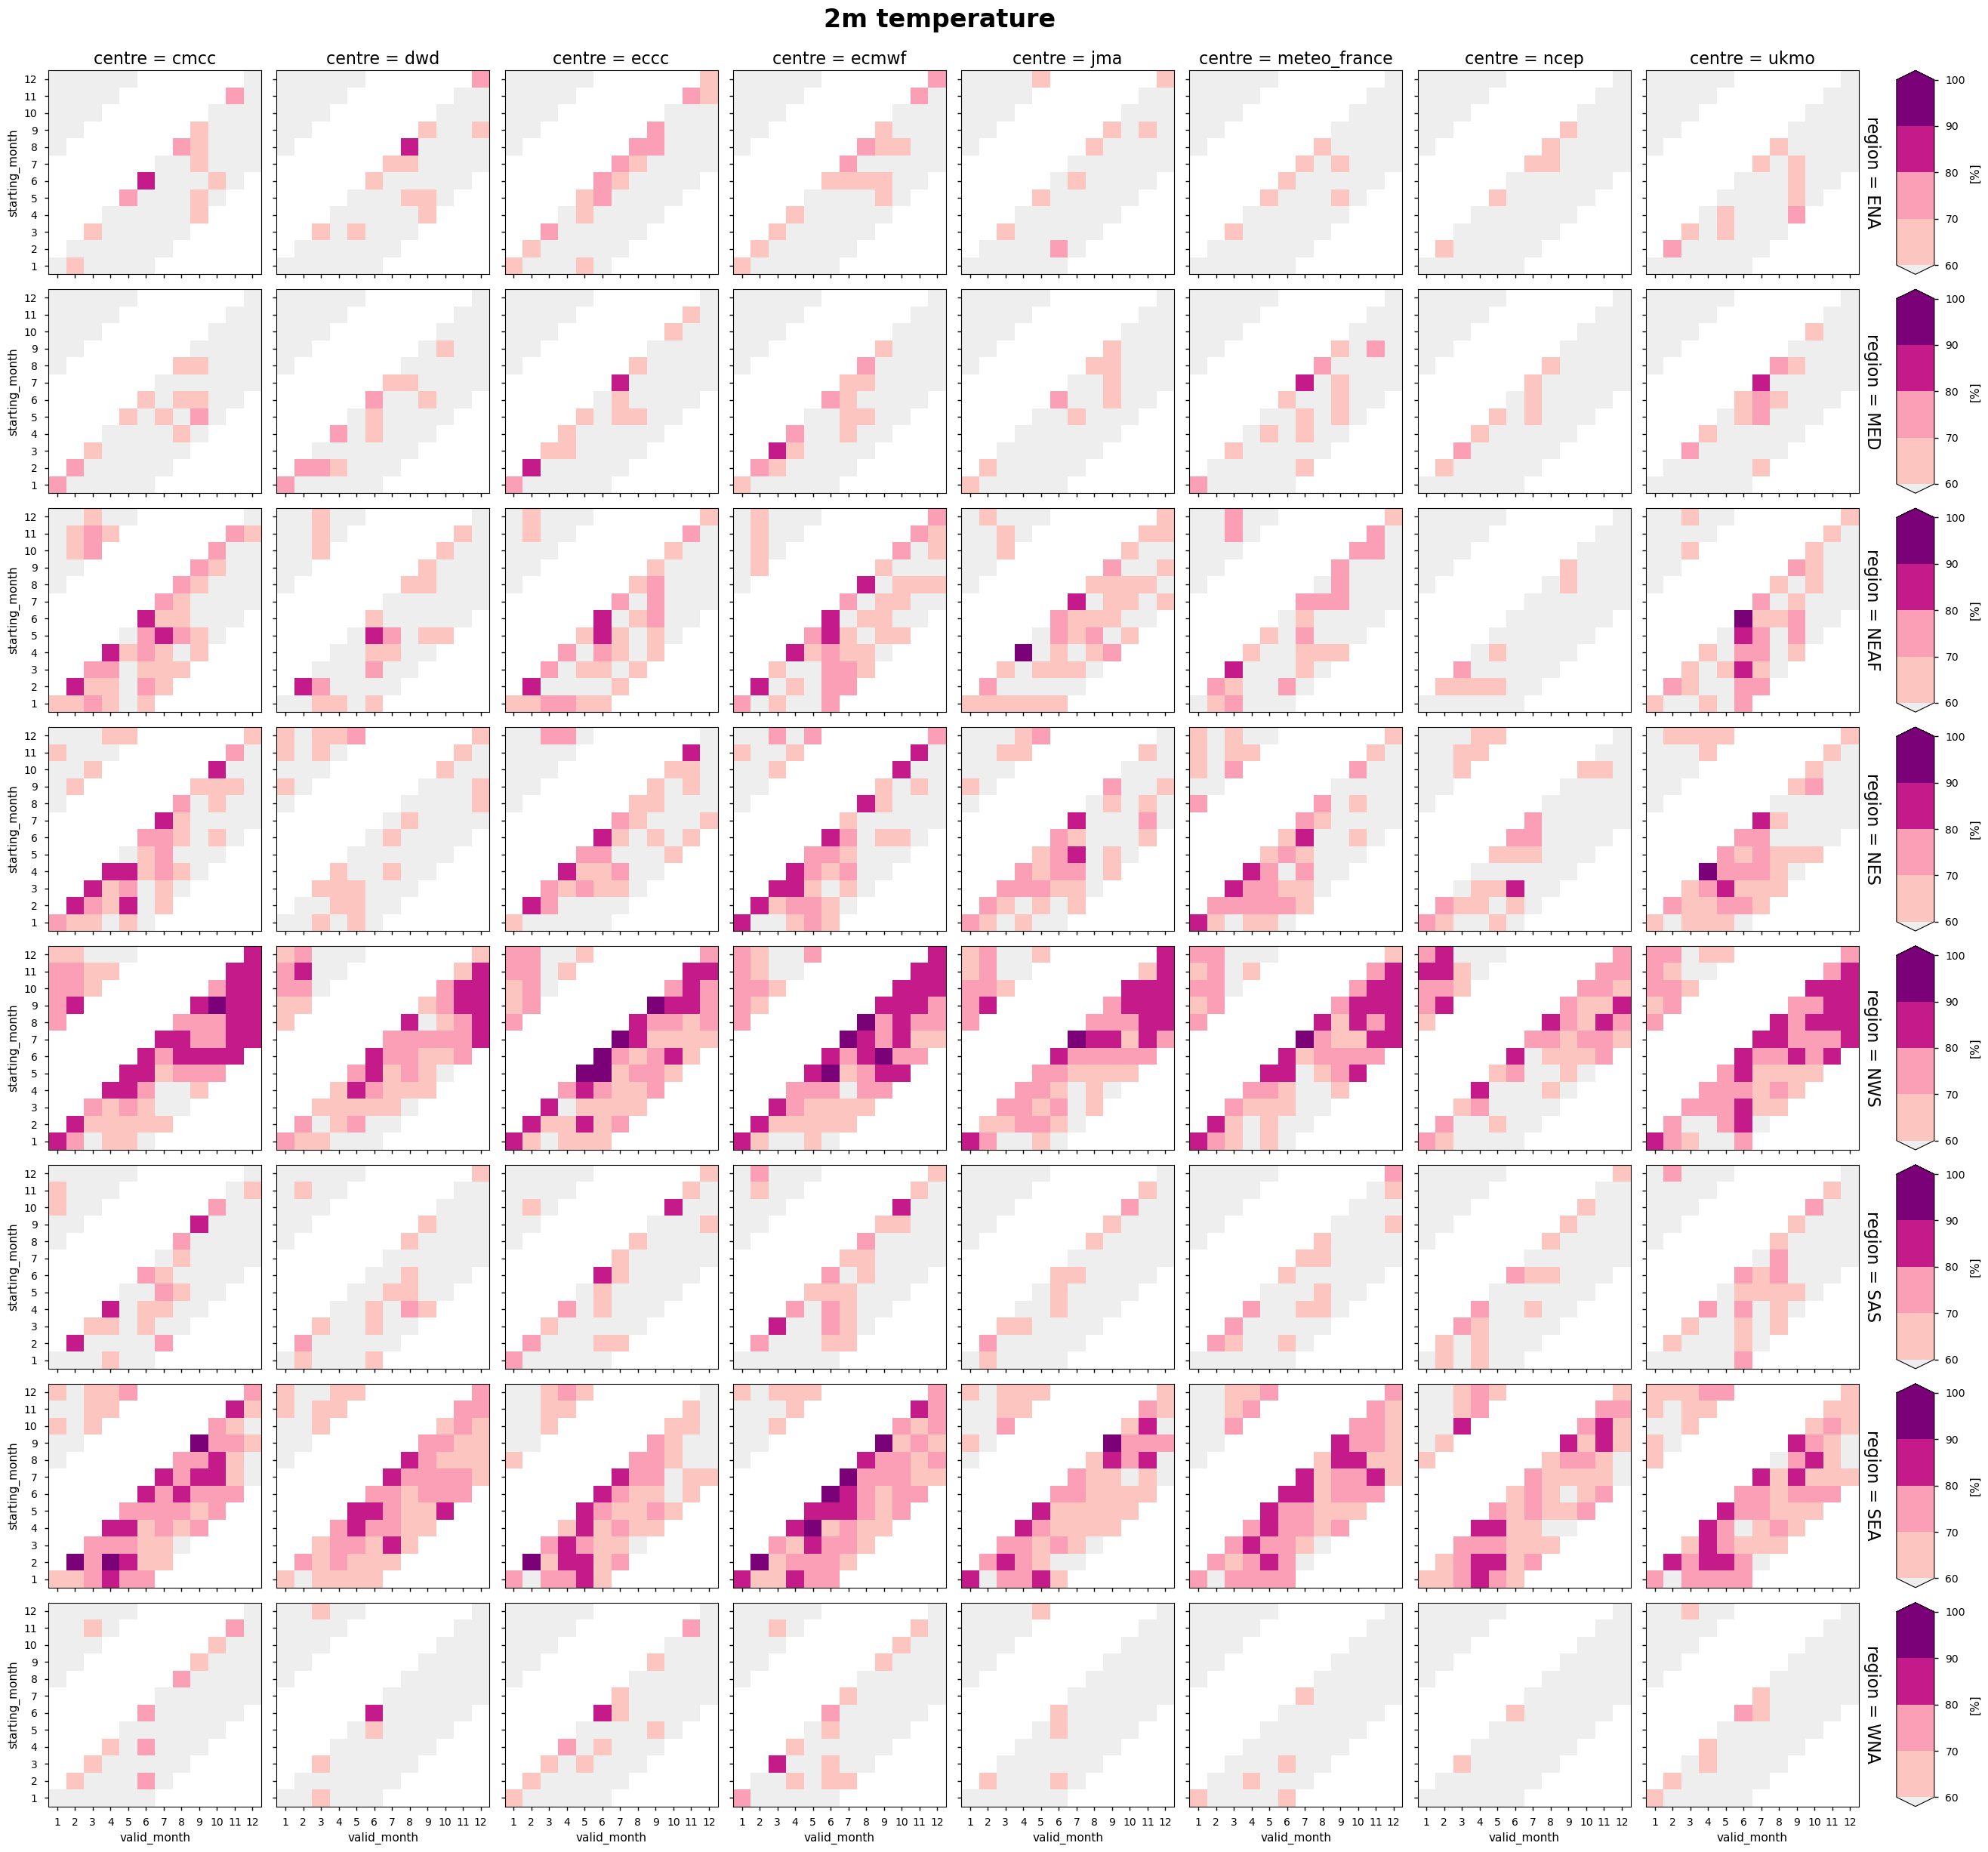

In [11]:
cbar_width = cbar_pad = 0.02

for var, da in hit_rate_mask.data_vars.items():
  if var == '2m_temperature':
    da.attrs = {"long_name": "Hit-Rate", "units": "%"}
    facet = da.plot(
        col="centre",
        row="region",
        x="valid_month",
        xticks=range(1, 13),
        yticks=range(1, 13),
        cmap=custom_cmap,
        extend='both',
        levels = np.arange(60.,110.,10.),
        add_colorbar=False
    )
    facet.fig.suptitle(f"{da.name.replace('_', ' ')}",  y=1.02, fontsize=24, fontweight='bold')
    facet.set_titles(fontsize=16)

    # Create a colorbar for each row
    for ax in facet.axs[:, -1]:
        pos = ax.get_position()
        cax = facet.fig.add_axes([pos.x1 + cbar_pad, pos.y0, cbar_width, pos.height])
        facet.fig.colorbar(
            ax.collections[0],
            cax=cax,
            label=f"[{da.attrs['units']}]"
        )
        
    plt.show()


#### Hit-rate for other variables

A similar analysis can be conducted for other variables such as monthly accumulated rainfall, wind speed, solar radiation and dew point temperature.

* For **total precipitation** the hit-rate for terciles of monthly anomalies is mostly very small, except for the NES and SEA. Notably, the window of predictability is concentrated in specific seasons: March-May for NES and June-November for SEA [[11]](https://doi.org/10.1175/JHM-D-19-0095.1)

* For **surface solar radiation downwards** the only region with potentially exploitables hit-rates is South East Asia (SEA);  limited hit-rate reported over Europe. [[12]](https://doi.org/10.5194/essd-13-2701-2021) [[13]](https://doi.org/10.1016/j.renene.2019.03.134).

* For **10m wind speed** seasonal forecasts produce only limited cases of hit-rates above 60% and only at very short lead times. [[14]](https://doi.org/10.1016/j.renene.2019.04.135).

* For **2m dew point temperature** the pattern of significant hit-rates is clearly linked to the hit-rates of **2m temperature** coherently with an approximately constant pattern of relative humidity whereby the dewpoint temperature is directly related to local temperature by the Clausius-Clapeyron relation [[11]](https://doi.org/10.1175/JHM-D-19-0095.1).

Similarly to **2m temperature** hit-rates for terciles of seasonal forecasts for other variables have a weak dependence on the originating centres.

The analysis highlights how seasonal forecasts provide a significant hit-rate for terciles of anomalies observed at a monthly time scale mainly for some specific areas and variables.

Nevertheless, valuable information can be extracted by conducting tailored analysis for specific applications [[3]](https://doi.org/10.1002/wcc.523).

Overall, this analysis highlights how seasonal forecasts can not be used as an extension of weather predictions to derive information on expected climate anomalies at monthly or shorter time scales. The actual added value of the use of seasonal forecasts should be always assessed on the basis of the specific applications and decision making processes. Other use cases can be sensitive to different indicators of the quality of seasonal forecasts such as the chance above normal of multiple categories (see for example the [Met Office 3-month outlooks](https://www.metoffice.gov.uk/binaries/content/assets/metofficegovuk/pdf/business/public-sector/civil-contingency/3moutlook_jja_v2.pdf)) or the possibility of anticipating the likelihood of extreme events [[16]](https://doi.org/10.1038/s41467-023-42377-1).

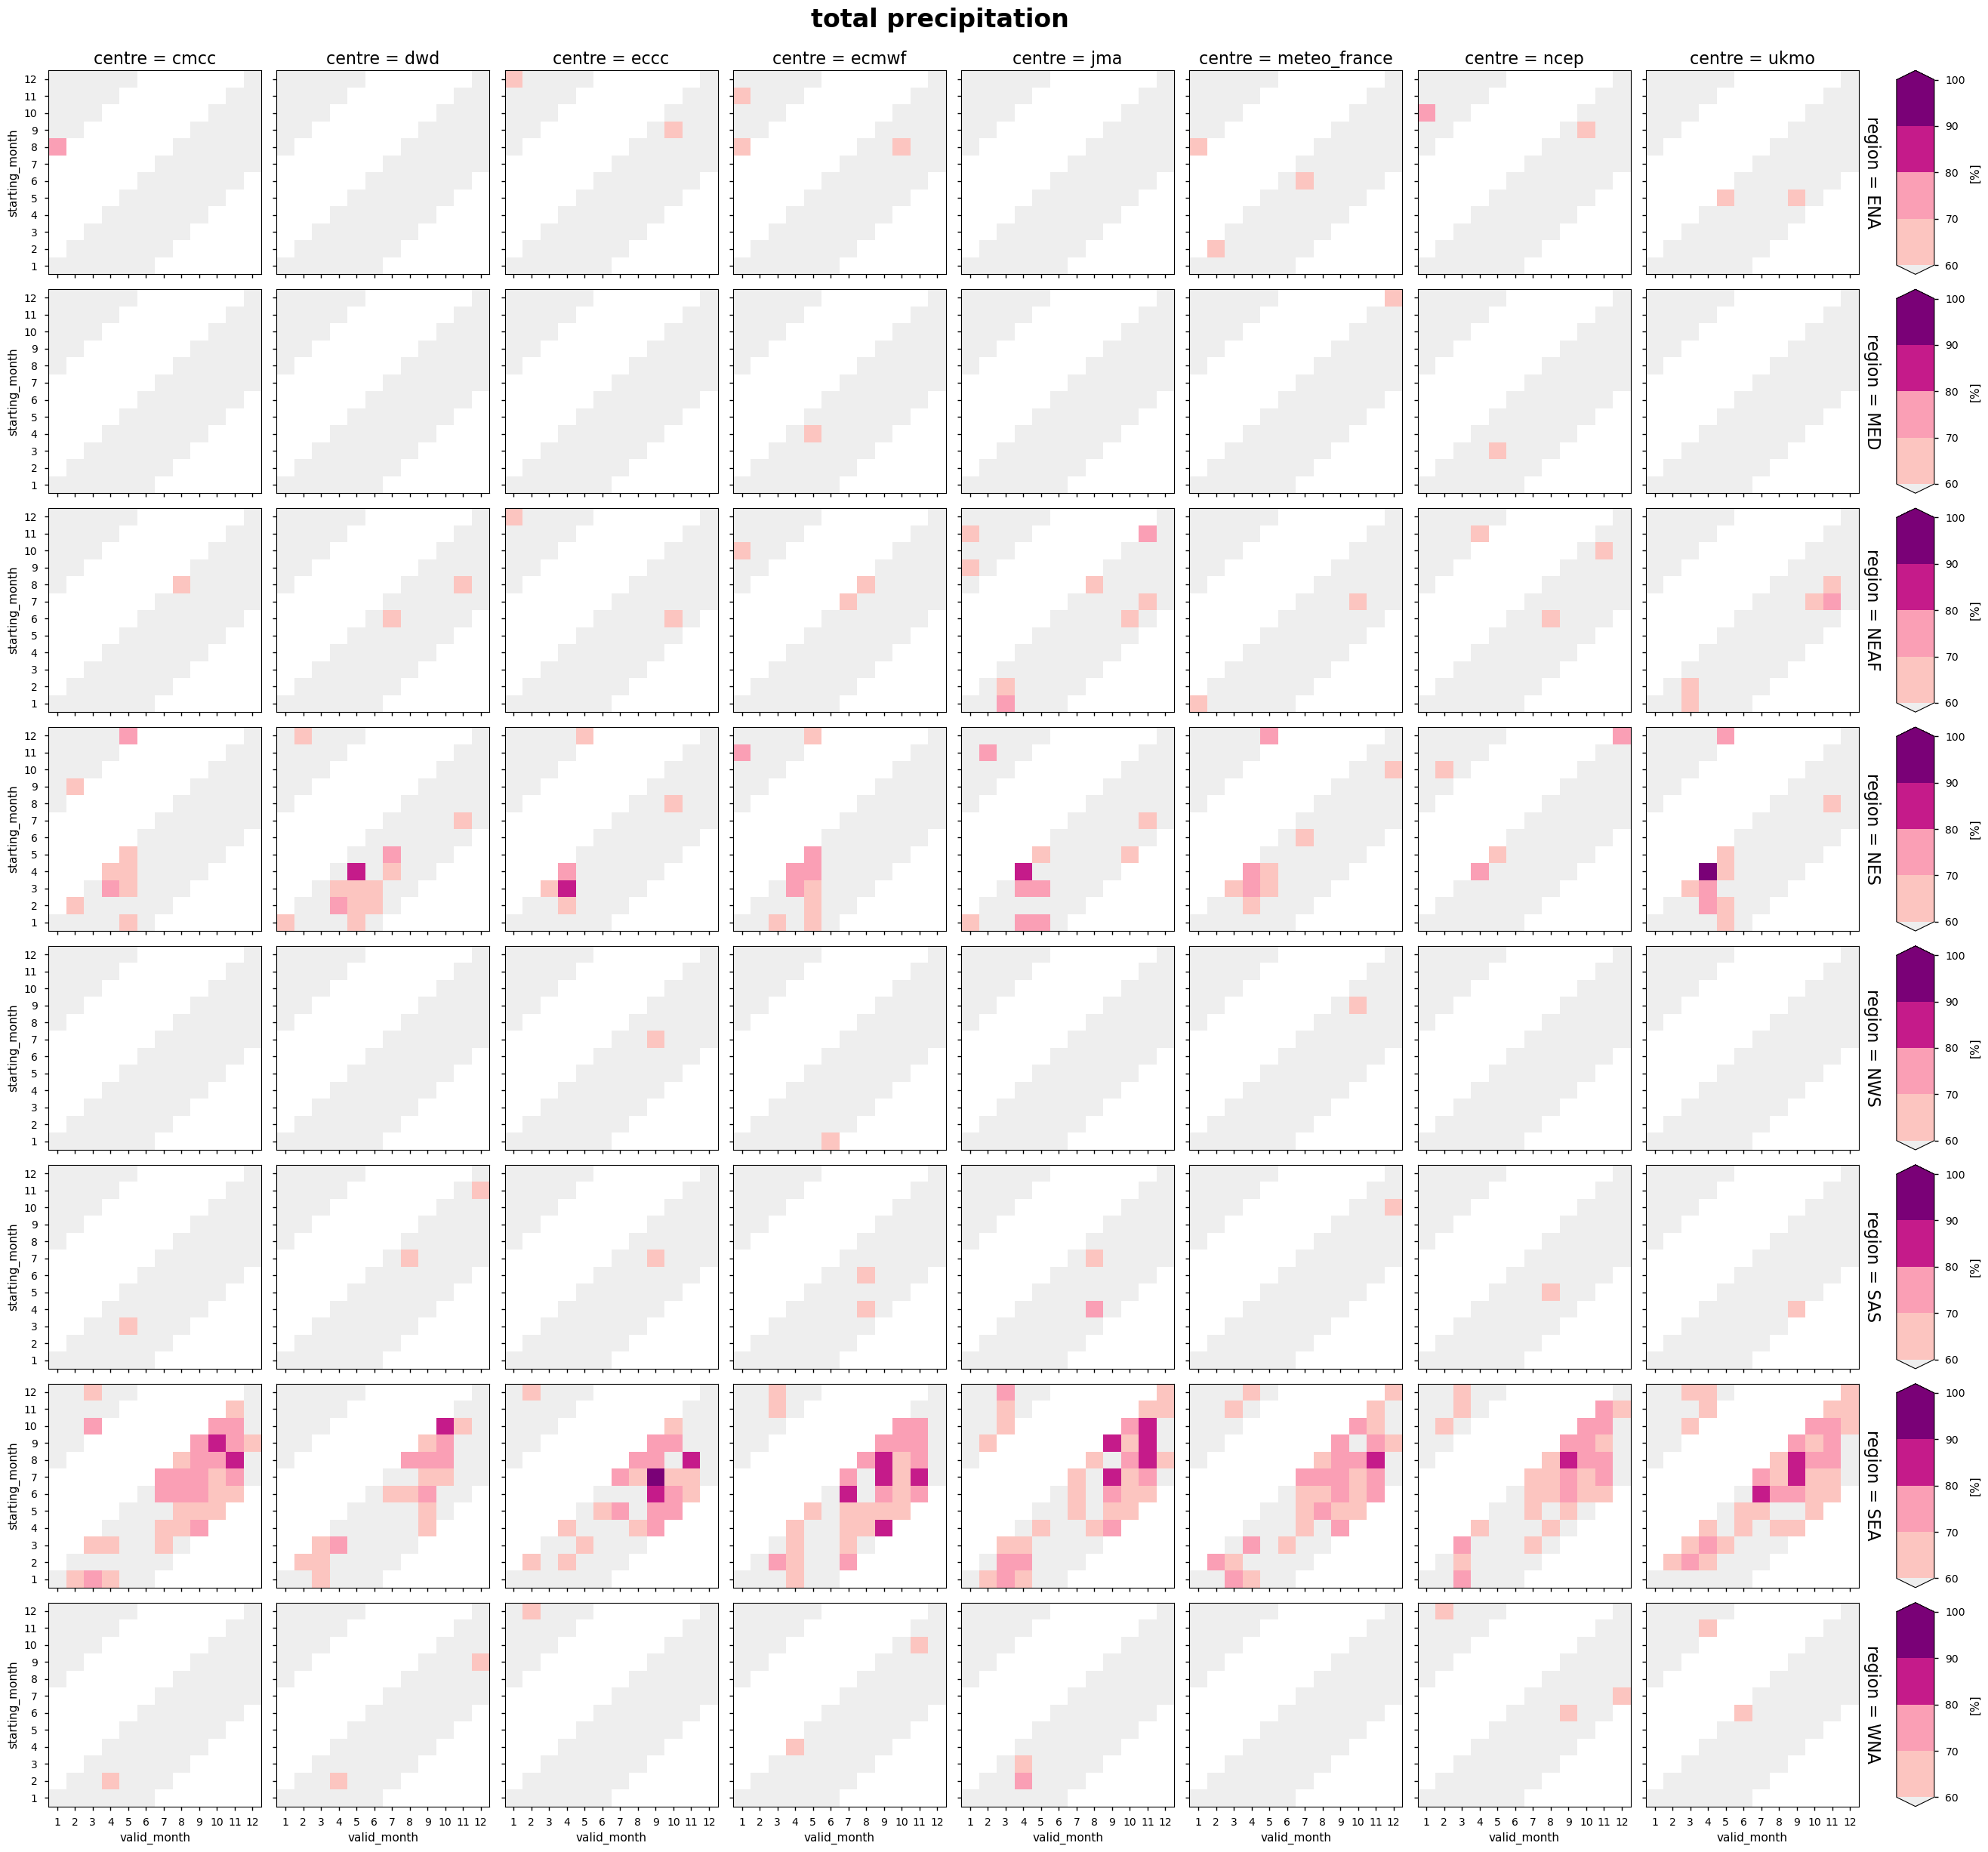

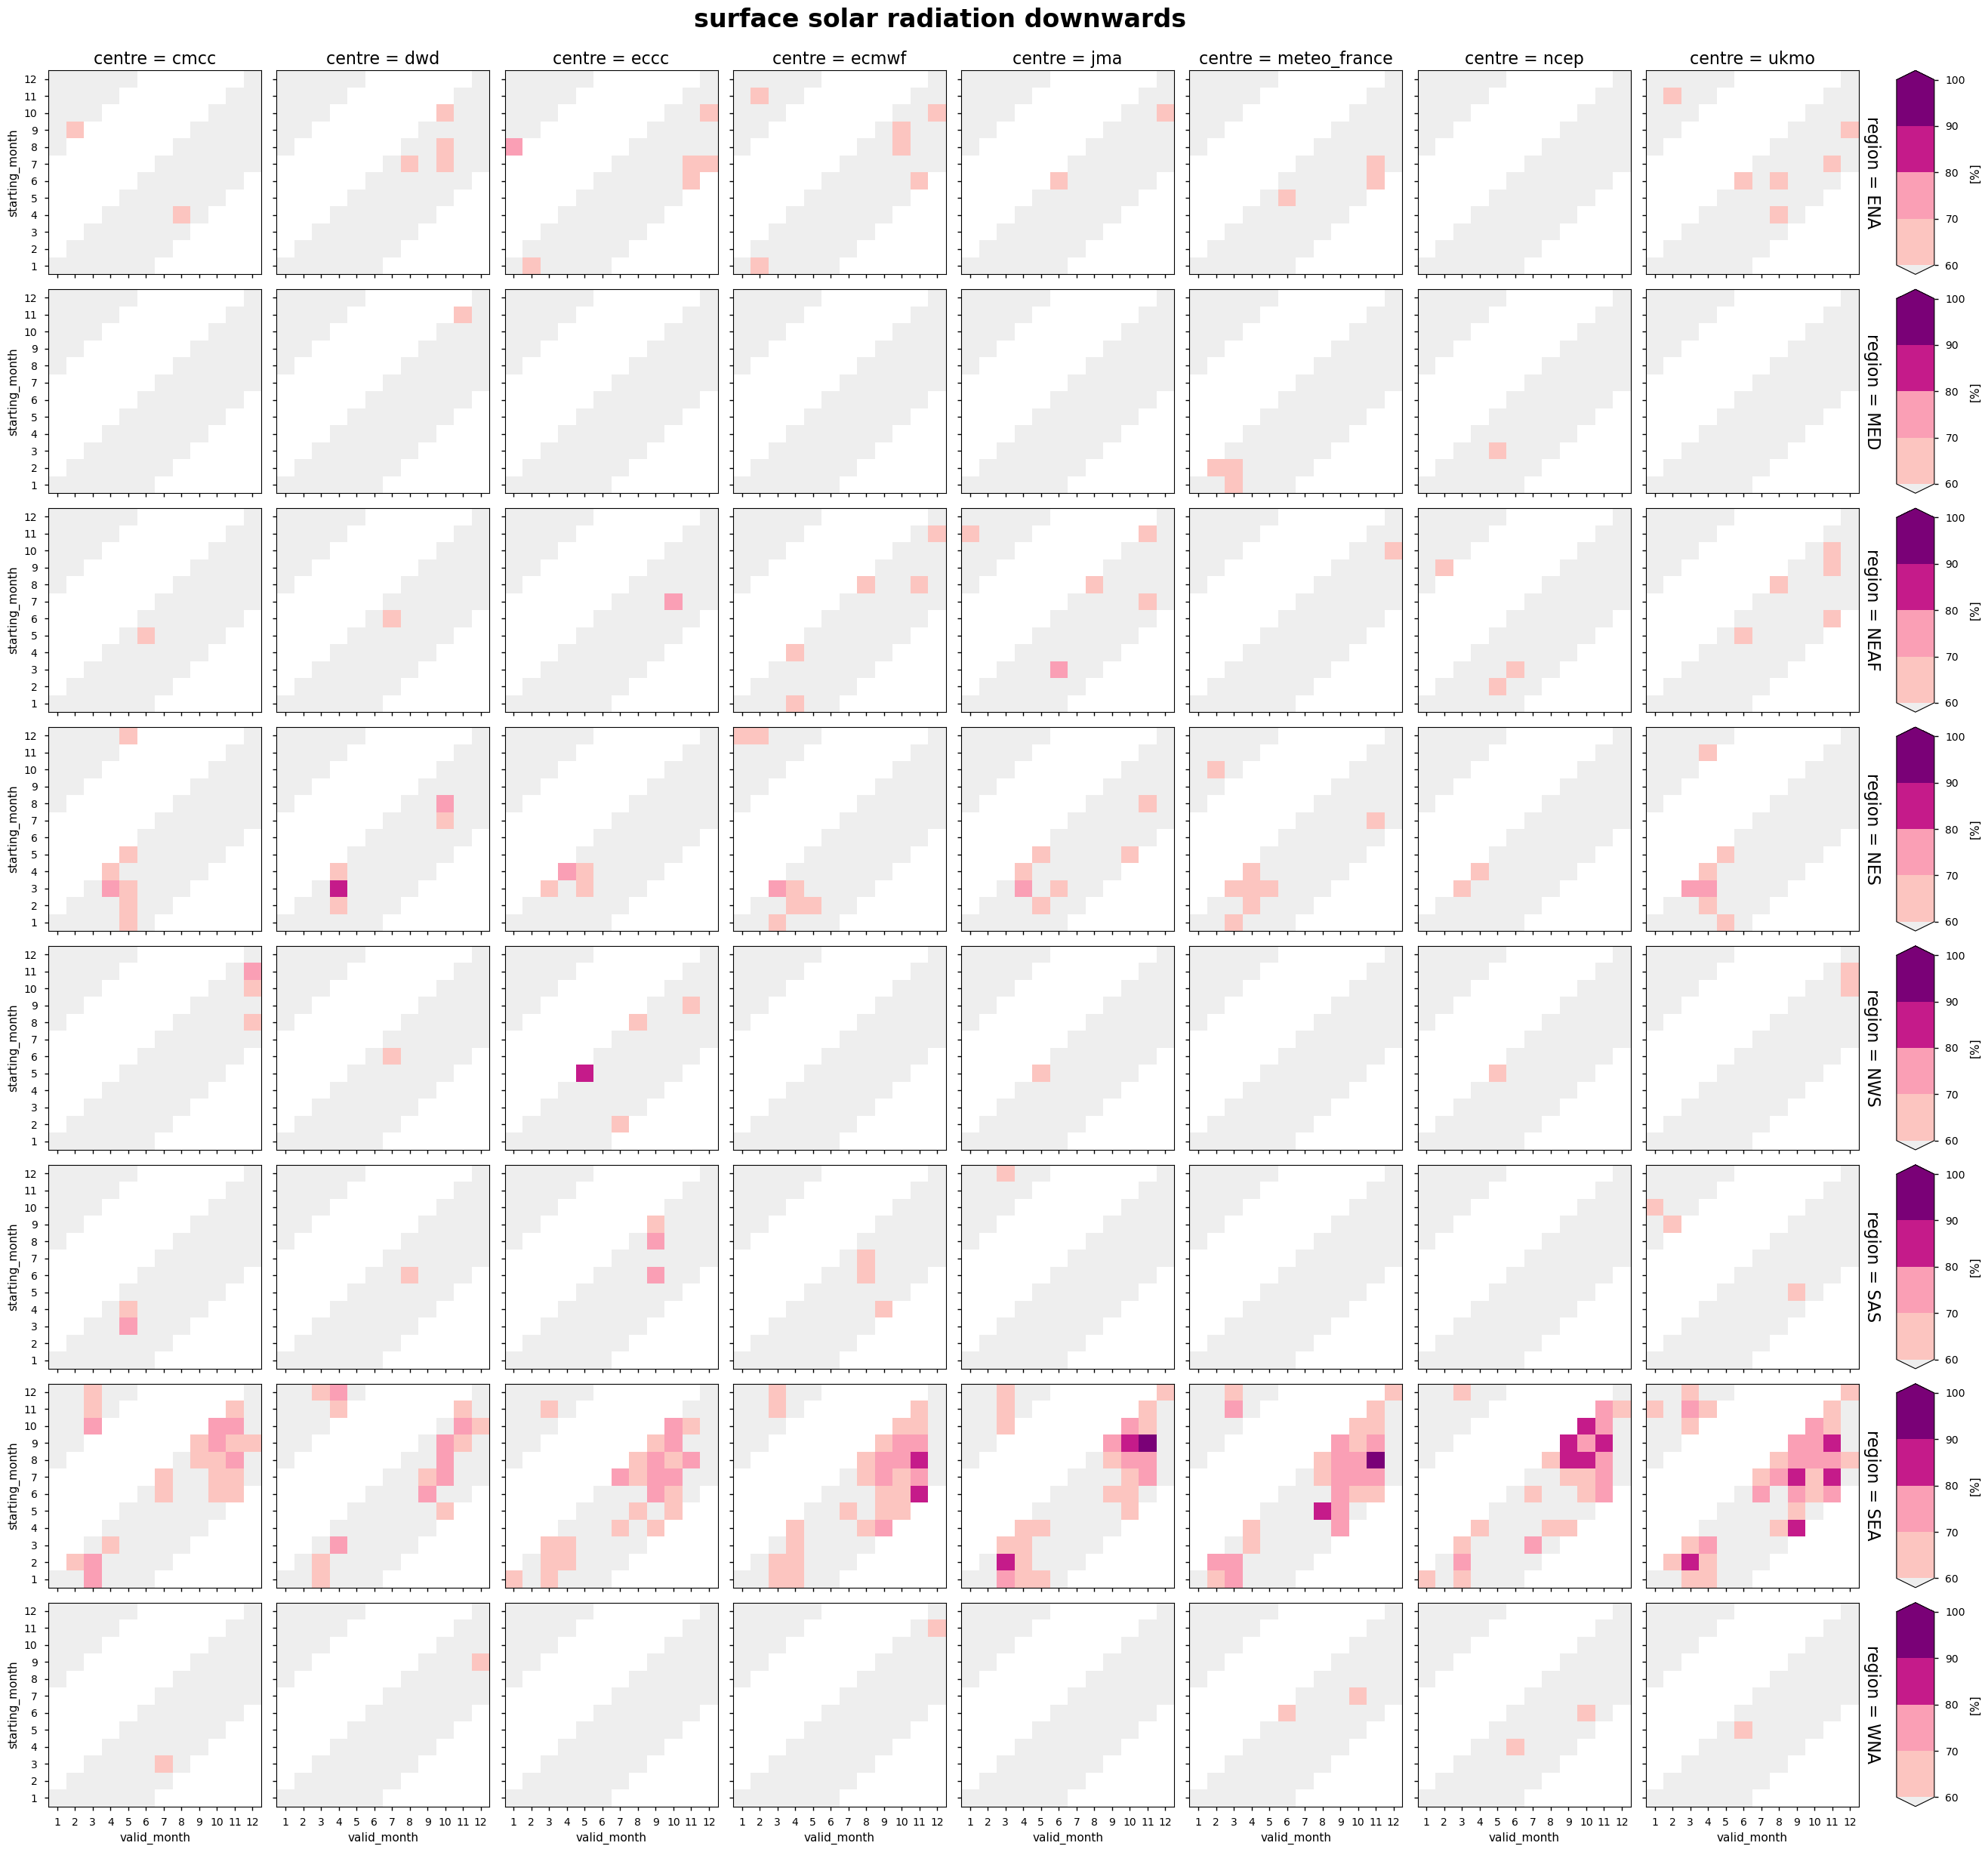

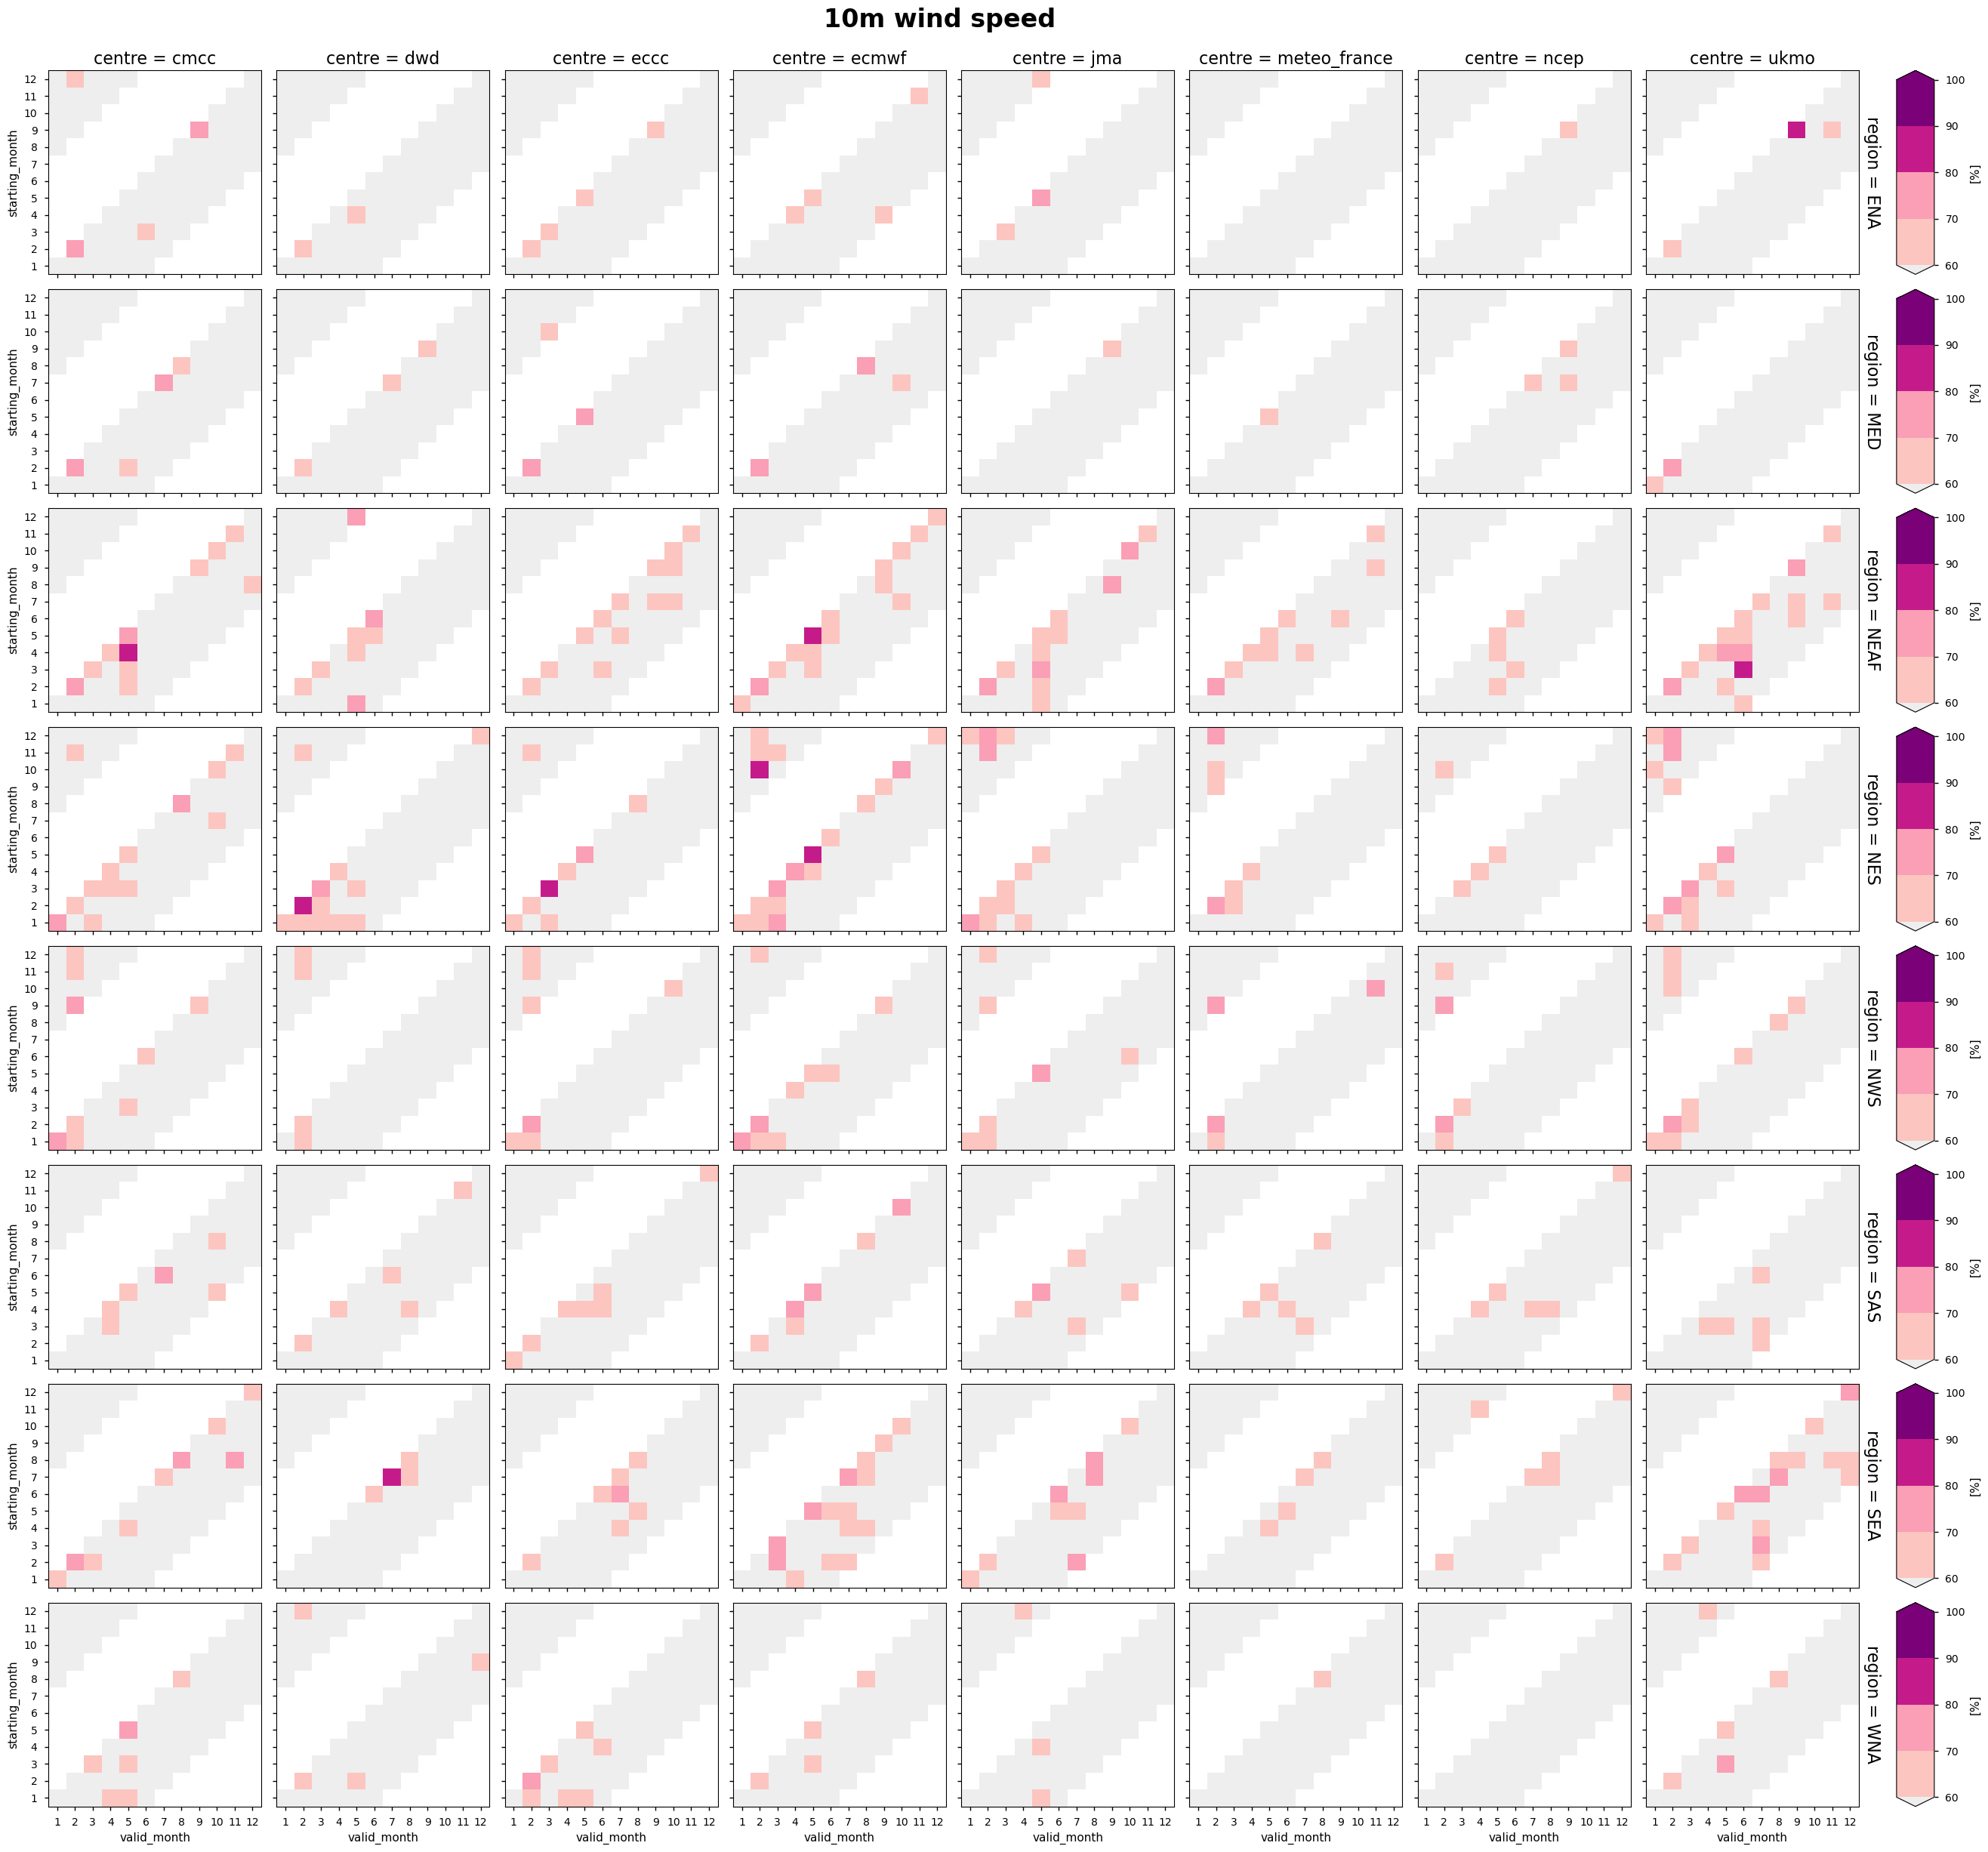

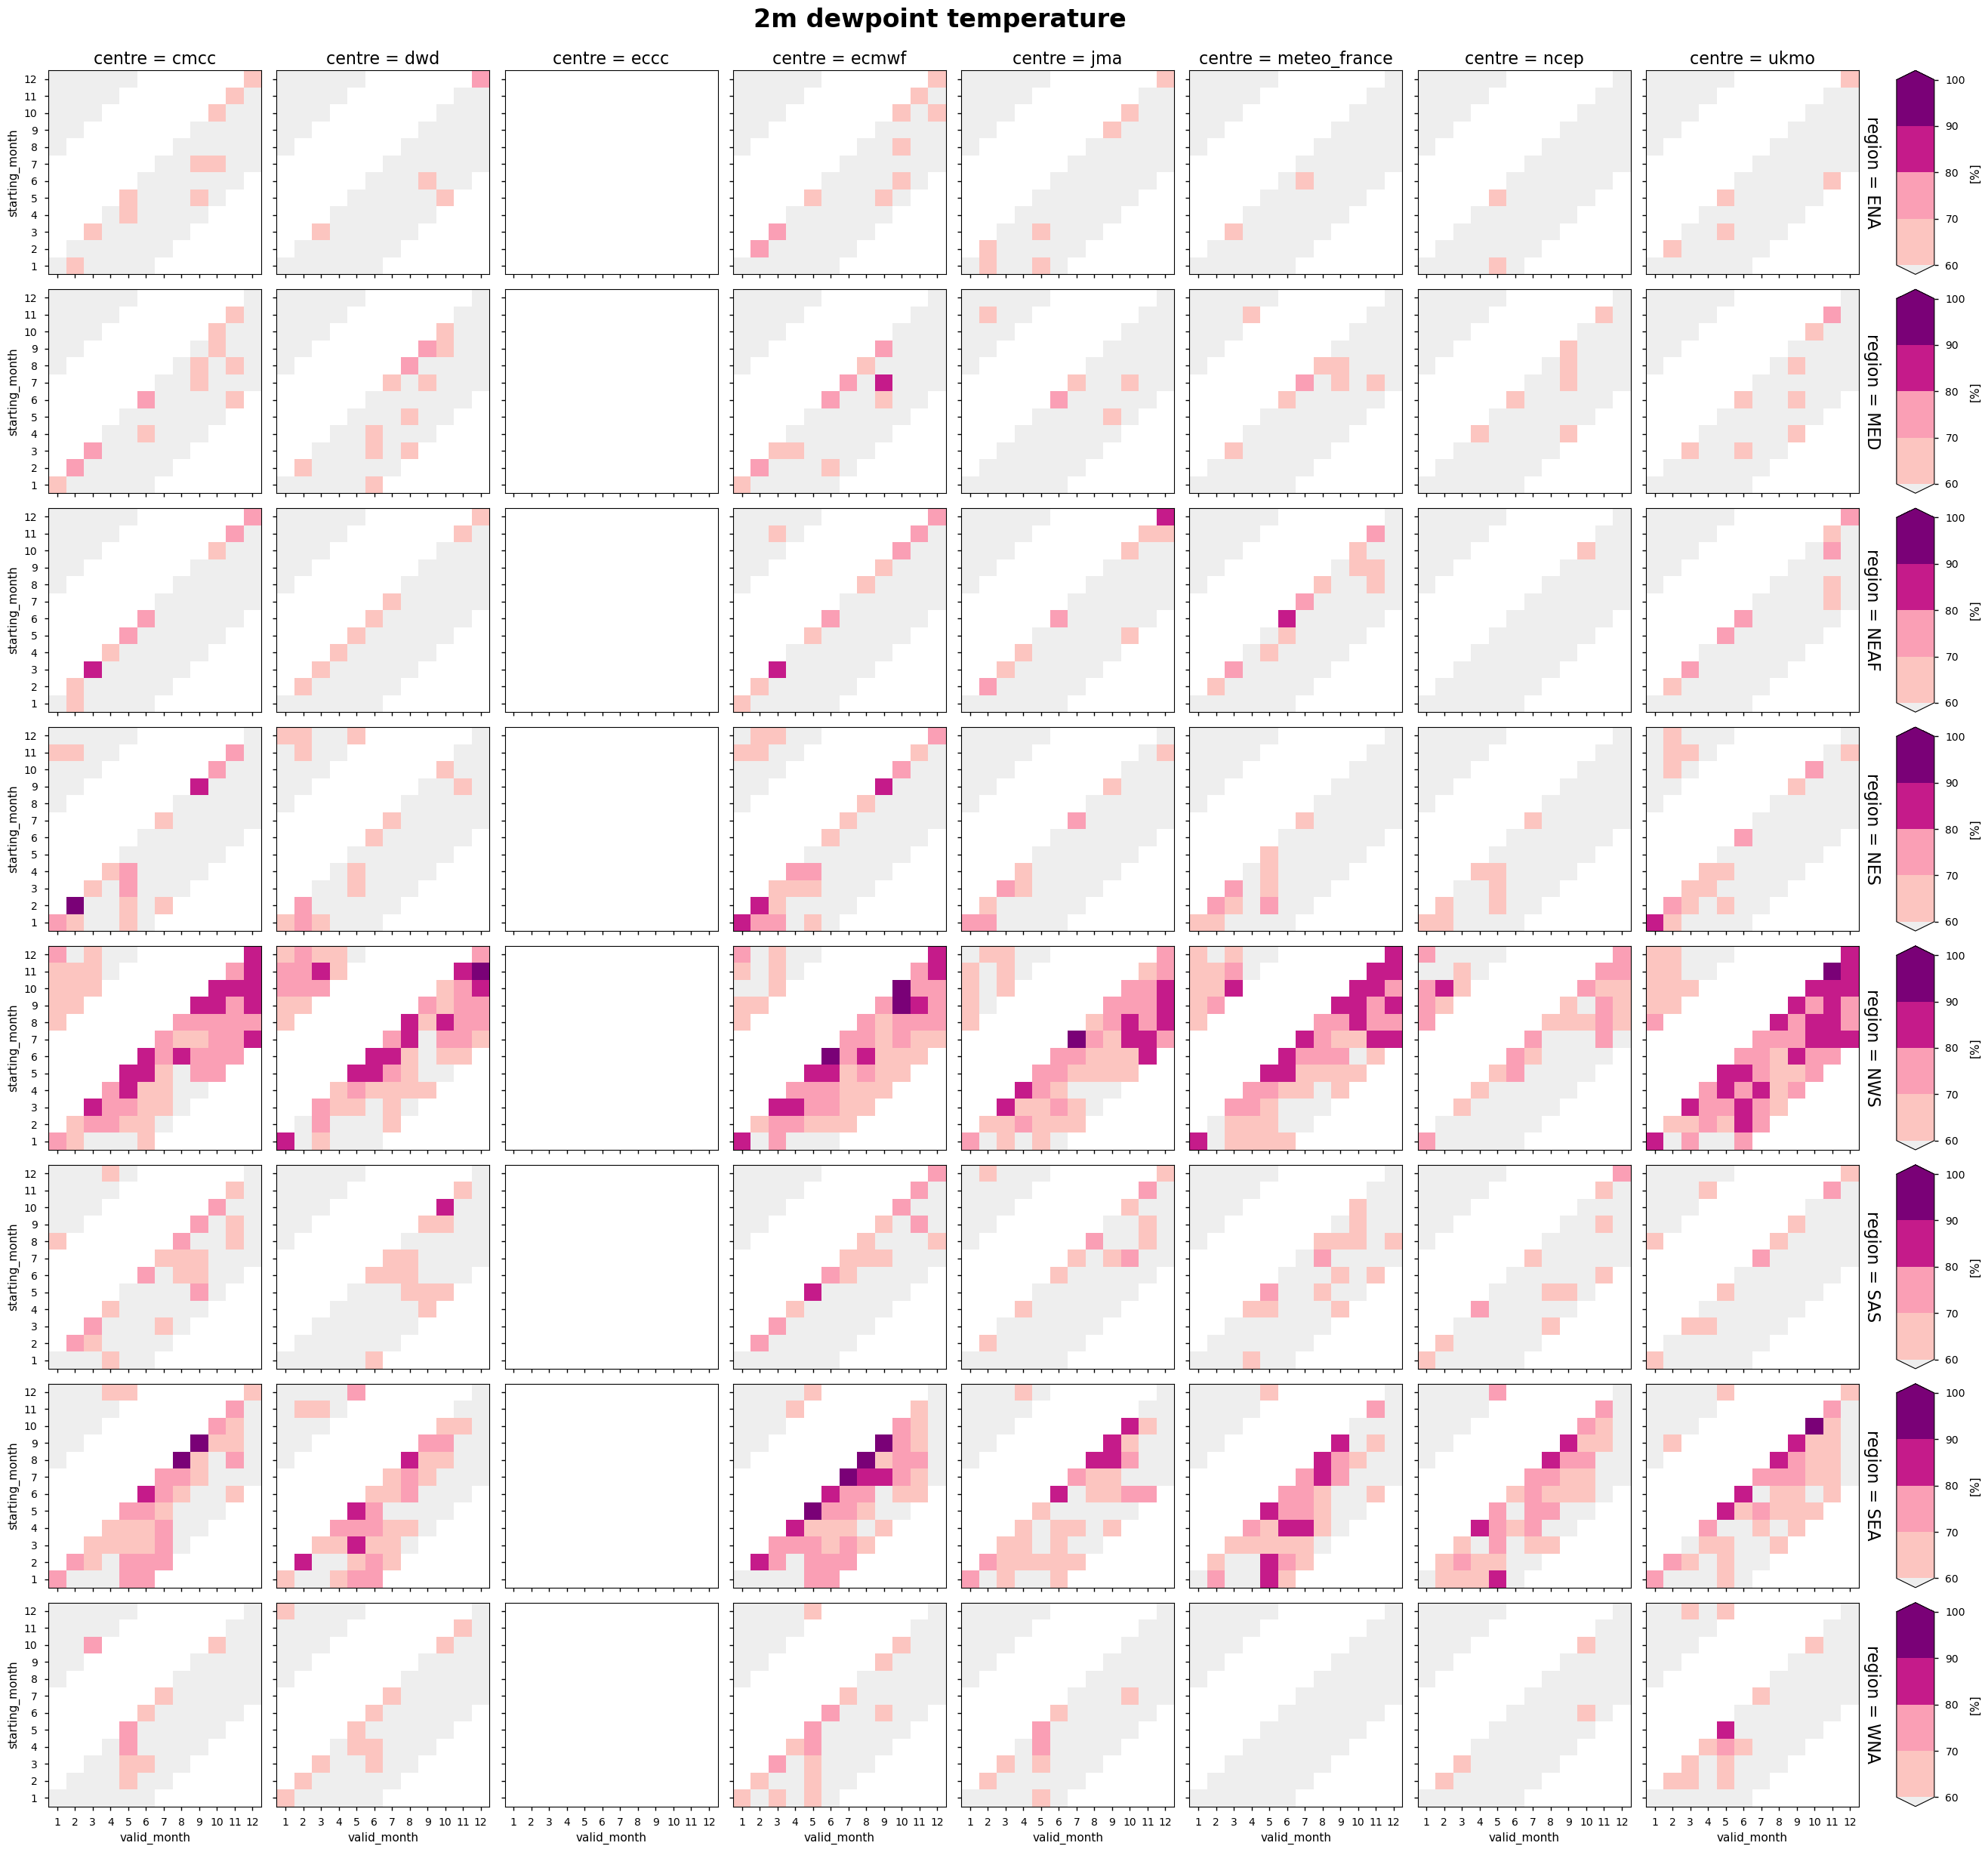

In [12]:
cbar_width = cbar_pad = 0.02

for var, da in hit_rate_mask.data_vars.items():
  if var != '2m_temperature':
    da.attrs = {"long_name": "Hit-Rate", "units": "%"}
    facet = da.plot(
        col="centre",
        row="region",
        x="valid_month",
        xticks=range(1, 13),
        yticks=range(1, 13),
        cmap=custom_cmap,
        extend='both',
        levels = np.arange(60.,110.,10.),
        add_colorbar=False
    )
    facet.fig.suptitle(f"{da.name.replace('_', ' ')}",  y=1.02, fontsize=24, fontweight='bold')
    facet.set_titles(fontsize=16)

    # Create a colorbar for each row
    for ax in facet.axs[:, -1]:
        pos = ax.get_position()
        cax = facet.fig.add_axes([pos.x1 + cbar_pad, pos.y0, cbar_width, pos.height])
        facet.fig.colorbar(
            ax.collections[0],
            cax=cax,
            label=f"[{da.attrs['units']}]"
        )
        
    plt.show()

## ℹ️ If you want to know more

### Key resources

The CDS catalogue entries for the data used were:
* Seasonal forecast monthly statistics on single levels: https://cds.climate.copernicus.eu/datasets/seasonal-monthly-single-levels?tab=overview
* ERA5 monthly averaged data on single levels from 1940 to present: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=overview

More information on the verification of forecasts are available on the [Forecast User Guide](https://confluence.ecmwf.int/display/FUG/Forecast+User+Guide) at ECMWF. In particular, key concepts on the use of contingency tables are discussed in the section dedicated to [Usefulness of the forecast and Cost/Benefit Approach](https://confluence.ecmwf.int/display/FUG/Section+12.A+Statistical+Concepts+-+Deterministic+Data#Section12.AStatisticalConceptsDeterministicData-UsefulnessoftheForecast-ACost/BenefitApproach)

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)
* The `regionmask` package for the computation of regionalised statistics is available [here](https://regionmask.readthedocs.io/en/stable/index.html)

### References

[[1]](https://doi.org/10.1016/j.cliser.2024.100496) Khosravi F,  Bruno Soares M, Teixeira M, Fontes N , Graca Antonio (2024), Assessing the usability and value of a climate service in the wine sector, Climate Services, Volume 34, 100496 

[[2]](https://doi.org/10.1038/s41612-023-00519-8) Ludescher, J., Bunde, A. & Schellnhuber, H.J (2023).  Forecasting the El Niño type well before the spring predictability barrier. npj Clim Atmos Sci 6, 196.

[[3]](https://doi.org/10.1002/wcc.523) Bruno Soares M., Daly M, Dessai S (2018) Assessing the value of seasonal climate forecasts for decision-making. WIREs Clim Change. 9:e523.   

[[4]](https://doi.org/10.1017/CBO9781139177245.006) Seneviratne, S. I., Nicholls, N., Easterling, D., Goodess, C. M., Kanae, S., Kossin, J., Zwiers, F. W. (2012). Changes in Climate Extremes and their Impacts on the Natural Physical Environment. In C. B. Field, V. Barros, T. F. Stocker, & Q. Dahe (Eds.), Managing the Risks of Extreme Events and Disasters to Advance Climate Change Adaptation: Special Report of the Intergovernmental Panel on Climate Change (pp. 109–230). chapter, Cambridge: Cambridge University Press. 

[[5]](https://doi.org/10.1016/j.crm.2021.100375) MacLeod D, Kniveton D R, Todd M C,(2021) Playing the long game: Anticipatory action based on seasonal forecasts, Climate Risk Management, Volume 34, 2021, 100375, 

[[6]](https://doi.org/10.1016/j.cliser.2023.100347) Terrado M, Marcos R,  González-Reviriego N, Vigo I, Nicodemou A, Graça A, Teixeira M, Fontes N, Silva S, Dell'Aquila A, Ponti L, Calmanti S, Bruno Soares M, Khosravi F, Caboni F, (2023) Co-production pathway of an end-to-end climate service for improved decision-making in the wine sector, Climate Services, Volume 30, 100347, 

[[7]](https://doi.org/10.1016/j.cliser.2023.100346) Dell'Aquila, A. Graça, A. Teixeira M Fontes N, Gonzalez-Reviriego N, Marcos-Matamoros R, Chou C, Terrado M, Giannakopoulos C, Varotsos K, Caboni F, Locci R, Nanu M, Porru S, Argiolas S, Bruno Soares M, Sanderson, M. Bruno Soares, M Sanderson, M. (2023)  Monitoring climate related risk and opportunities for the wine sector: The MED-GOLD pilot service, Climate Services, 2023, 30, 100346 

[[8]](https://doi.org/10.1175/BAMS-D-19-0019.1) Weisheimer, A., D. J. Befort, D. MacLeod, T. Palmer, C. O’Reilly, and K. Strømmen (2020) : Seasonal Forecasts of the Twentieth Century. Bull. Amer. Meteor. Soc., 101, E1413–E1426,  

[[9]](https://doi.org/10.1175/WAF-D-19-0106.1) Gubler, S., and Coauthors (2020)  Assessment of ECMWF SEAS5 Seasonal Forecast Performance over South America. Wea. Forecasting, 35, 561–584,  

[[10]](https://doi.org/10.1007/s00704-018-2421-9) Mohanty, U.C., Nageswararao, M.M., Sinha, P. et al. (2019) Evaluation of performance of seasonal precipitation prediction at regional scale over India. Theor Appl Climatol 135, 1123–1142

[[11]](https://doi.org/10.1175/JHM-D-19-0095.1) Roy, T., X. He, P. Lin, H. E. Beck, C. Castro, and E. F. Wood (2020) Global Evaluation of Seasonal Precipitation and Temperature Forecasts from NMME. J. Hydrometeor., 21, 2473–2486

[[12]](https://doi.org/10.5194/essd-13-2701-2021) Lorenz, C., Portele, T. C., Laux, P., and Kunstmann, H.(2021) Bias-corrected and spatially disaggregated seasonal forecasts: a long-term reference forecast product for the water sector in semi-arid regions, Earth Syst. Sci. Data, 13, 2701–2722,  

[[13]](https://doi.org/10.1016/j.renene.2019.03.134) De Felice M, Bruno Soares M, Alessandri A, Troccoli A,(2019) Scoping the potential usefulness of seasonal climate forecasts for solar power management, Renewable Energy, Volume 142, Pages 215-223, 

[[14]](https://doi.org/10.1016/j.renene.2019.04.135) Lledó Ll., Torralba V.,  Soret A, Ramon J, Doblas-Reyes FJ (2019) Seasonal forecasts of wind power generation, Renewable Energy, Volume 143, 91-100 

[[15]](https://doi.org/10.1098/rsif.2013.1162 ) Weisheimer A. and Palmer T. N. (2014) On the reliability of seasonal climate forecastsJ. R. Soc. Interface.1120131162 

[[16]](https://doi.org/10.1038/s41467-023-42377-1) Dunstone, N., Smith, D.M., Hardiman, S.C. et al. Windows of opportunity for predicting seasonal climate extremes highlighted by the Pakistan floods of 2022. Nat Commun 14, 6544 (2023). 